In [249]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Process Mining - Insights into a Fine Management Process

by Johannes Bock

In the following case study I want to showcase the power of process mining and its ability to identify inefficiencies and bottlenecks in business processes. 

Organizations have information systems such as SAP-ERP that record all activities and processes in massive log databases. In the past, such event logs were mainly used for the purpose of record-keeping, accounting, auditing, etc. More recently, organizations have started leveraging those data sources for business analytics. 

Process mining uses these event logs in order to understand how an organization works and discovers the sequence of tasks that are performed in a certain business process. By doing so, the performance of As-Is processes can be benchmarked to the target processes and potential sources for improvement can be identified. 

The following case study is based on a [real-life event log dataset](https://data.4tu.nl/repository/uuid:270fd440-1057-4fb9-89a9-b699b47990f5), which is provided by the local police of an Italian city, and will analyse its fine management process.

In [2]:
# Read xes datafile

import datetime
import xml.etree.ElementTree as ET
import csv
    
tree = ET.parse('sample_data/Road_Traffic_Fine_Management_Process.xes')
root = tree.getroot()
ns = {'xes': 'http://www.xes-standard.org/'}

with open('logs.csv', 'wb') as csvfile:
    #Write header
    w = csv.writer(csvfile)
    w.writerow(["caseid", "task", "event_type", "user", "timestamp"])
    
    for trace in root.findall('trace'): #{http://www.xes-standard.org}
        caseid = ''
        for string in trace.findall('string', ns):

            if string.attrib['key'] == 'concept:name':
                caseid = string.attrib['value']
        for event in trace.findall('event', ns):
            task = ''
            user = ''
            event_type = ''
            for string in event.findall('string', ns):
                if string.attrib['key'] == 'concept:name':
                    task = string.attrib['value']
                if string.attrib['key'] == 'org:resource':
                    user = string.attrib['value']
                if string.attrib['key'] == 'lifecycle:transition':
                    event_type = string.attrib['value']
                timestamp = ''
                for date in event.findall('date', ns):
                    if date.attrib['key'] == 'time:timestamp':
                        timestamp = date.attrib['value']
                        timestamp = datetime.datetime.strptime(timestamp[:-6], #-10
                                    '%Y-%m-%dT%H:%M:%S')
                    if task:
                        w.writerow([caseid, task, event_type, user, str(timestamp)])

In [3]:
import pandas as pd

logs = pd.read_csv("logs.csv")
logs = logs.loc[logs["event_type"]=="complete",:]
logs.to_csv("logs_clean.csv",index=False)
logs.head(5)

,caseid,task,event_type,user,timestamp
2,A1,Create Fine,complete,561.0,2006-07-24 00:00:00
4,A1,Send Fine,complete,NaN,2006-12-05 00:00:00
7,A100,Create Fine,complete,561.0,2006-08-02 00:00:00
9,A100,Send Fine,complete,NaN,2006-12-12 00:00:00
11,A100,Insert Fine Notification,complete,NaN,2007-01-15 00:00:00


In [167]:
print "Total number of cases: ", logs["caseid"].nunique()

Total number of cases:  150370


The log data contains information about **more than 150,000** road-traffic fines cases. The events relate to notifications, payments, and appeals.

In [4]:
# Read in the logs
import datetime

f = open('logs_clean.csv', 'r')

log = dict()
filter_by = None #A_

for line in f:
    line = line.strip()
    if line == "caseid,task,event_type,user,timestamp":
        continue
    if len(line) == 0:
        continue
    parts = line.split(',')
    caseid = parts[0]
    task = parts[1]
    user = parts[3]

    timestamp = datetime.datetime.strptime(parts[4], '%Y-%m-%d %H:%M:%S')
    if caseid not in log:
        log[caseid] = []
    event = (task, user, timestamp)
    
    if filter_by:
        if task.startswith(filter_by):
            log[caseid].append(event)
    else:
        log[caseid].append(event)

f.close()

#Sort data
for caseid in sorted(log.keys()):
    log[caseid].sort(key = lambda event: event[-1])

## Process Variants

As in some cases payments are late, additionally penalties are incurred or credit needs to be collected by the police, not all of the cases go through one identical process. In this section I will identify the different fine management process variants and filter the most common processes for detailed analysis.

In [168]:
# Compute Process Variants
log_df = []
for case in log:
    for row in log[case]:
        log_df.append({"caseid":case,"task":row[0],"timestamp":row[2]})
log_df = pd.DataFrame.from_dict(log_df)

#Sort each case by timestamp and get sorted list of process steps for each case

new = log_df.sort_values(['caseid','timestamp'],ascending=True).groupby("caseid")
processes =[] 
for group in new:
    processes.append({"process":list(group[1]["task"]),"caseid":group[0]})
processes = pd.DataFrame.from_dict(processes)
processes["process"] = processes["process"].astype(str)

In [226]:
import ast

def get_paths(steps):
    steps = ast.literal_eval(steps)
    paths = ""
    for i in range(len(steps)-1):
        paths = paths + steps[i]+"->"+steps[i+1]+","
    return paths[:-1]

In [169]:
# Find duplicate process Variants and combine in a summary table
variants = []
for i,variant in enumerate(processes.groupby("process")):
    variants.append({"variant":"variant","process":variant[0],"caseids":list(variant[1]["caseid"]),
                     "num_cases":len(list(variant[1]["caseid"]))})
variants = pd.DataFrame.from_dict(variants)
variants.sort_values("num_cases",ascending=False, inplace=True)
variants.reset_index(inplace=True,drop=True)
variants["variant"]= variants.variant.str.cat(variants.index.astype(str))
variants["share"] = variants["num_cases"]*100./variants["num_cases"].sum()
variants["paths"] = variants['process'].apply(get_paths)
print "Total number of fine management process variants: ",variants.shape[0]

Total number of fine management process variants:  261


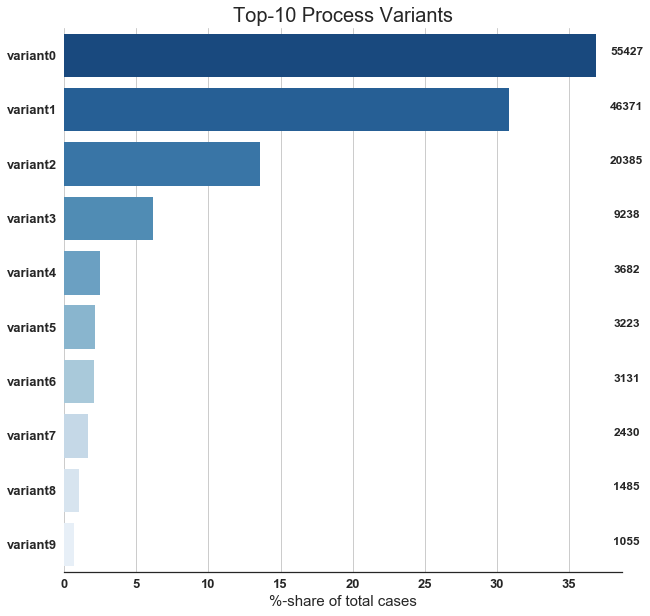

In [73]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 

sns.set_style("white")

plt.figure(figsize=(10,10))
ax = sns.barplot(x="share",y="variant",data = variants.loc[0:9,:],orient="h",palette = "Blues_r")
plt.title("Top-10 Process Variants",fontsize=20)
plt.xlabel("%-share of total cases",fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("")

for i,p in enumerate(ax.patches):
    text_list = list(variants.loc[0:9,"num_cases"])
    ax.text(x=p.get_x()+39,y=p.get_y()+p.get_height()/2,s=text_list[(i)],ha="center",fontsize=12)

ax.xaxis.grid()
sns.despine(left=True)
plt.show()

It turns out that the 150k cases follow a total of **261** different process variants. However, the most common processes make up the majority of the cases in the data set. Hence, the top-3 most common process variants account for about **80 %** of all cases.

## Process Visualization & Analysis

In order to understand how the road traffic fine management process works, I will now analyse the process flow, its most common sequences of tasks and performance.

In [184]:
from utils import *

A,F,D,stats = prepare_process_data(log, variants, time_metric="mean",top_variants = 10)

In [228]:
# Save choosen variants and its paths
variants.loc[0:9,["variant","paths"]].to_csv("paths.csv",index=False)

In [233]:
print '\033[1m' + "Animated Process Flow (Case counts)"
print '\033[0m'
print "Number of process variants: ", stats[8]
print "Total number of cases: ",stats[6]
print "%-share of all cases: ",round(stats[7],2),"%"
    
from IPython.core.display import HTML

HTML('<iframe src="vis/animated_process.html" width="80%" height="750" seamless>Kann nicht angezeigt werden.</iframe>')

Animated Process Flow (Case counts)

Number of process variants:  10
Total number of cases:  146427
%-share of all cases:  97.38 %


In the chart above I have visualized the Top-10 process variants which account for about **97 %** of all cases. Hence, if we understand the process flow of these 10 variants, we understand almost all different sequences of tasks. Using the interactive buttons on the bottom, you can explore the flow of tasks for each different variant.

When clicking through the variants, it turns out that especially **variant1** and **variant2** are somewhat special, as the cases after they have been created either only move to status "Send Fine" or "Payment". **Variant1** could be all cases which are not closed yet and therefore, only are very early in the process. However, **variant2** requires more research, since these cases proceed to the "Payment" stage even though the fine has not been sent out yet.

Interestingly, the most common process **variant0**, which accounts for about **37 %** of all cases as we saw above, includes late payments, penalties and credit collection by the police. Hence, Italian traffic offenders not seem to be very reliable when it comes to paying their fines. 

Process Flow (Average time in days)

Number of process variants:  10
Total number of cases:  146427
%-share of all cases:  97.38 %


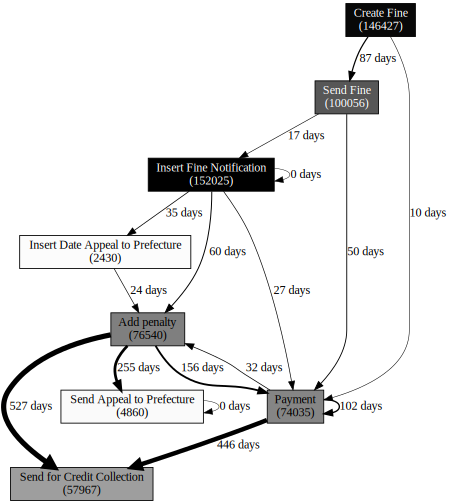

In [186]:
f = draw_process(A,F,D,stats, edge_stats = "time", min_line_thick = 0.5,max_line_thick = 6,plot_size = "7",
                title = "Process Flow (Average time in days)")
f

After we have understood the most common sequences of tasks, we can now move on and analyze the efficiency of the fine management process. In the chart above we can see the actual average time that each task takes based on a sample of roughly 146k cases. The longer the task takes the thicker are the arrows.

#### Three months on average until the fine is sent out to offenders
If you have already wondered why your Italian tickets take so long to reach you, now you have the evidence that the Italian police is just very slow. It takes them **87 days** on average to send out the fine.

#### More than 1.75 years on average until police collects fines from offenders
In at least 37% of the cases the Italian government has to wait a very long time of more than 1.75 years until it receives the cash from traffic offenders. This is way too long and it should be investigated further why the police waits **527 days** on average to send for credit collection after the first penalty was added.

In [236]:
A,F,D,stats = prepare_process_data(log, variants, time_metric="max",top_variants = 10)

Process Flow (Maximum time in days)

Number of process variants:  10
Total number of cases:  146427
%-share of all cases:  97.38 %


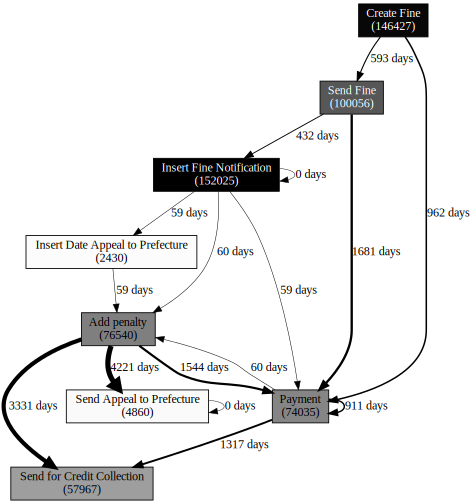

In [238]:
f = draw_process(A,F,D,stats, edge_stats = "time", min_line_thick = 0.5,max_line_thick = 6,plot_size = "7",
                title = "Process Flow (Maximum time in days)")
f

In order to see how bad it can get in terms of process efficiency, I also plotted the maximum time for each task. As expected it can get really bad. In one case it took more than **11 years** to send an appeal to the Prefecture.

In [239]:
A,F,D,stats = prepare_process_data(log, variants, time_metric="min",top_variants = 10)

Process Flow (Minimum time in days)

Number of process variants:  10
Total number of cases:  146427
%-share of all cases:  97.38 %


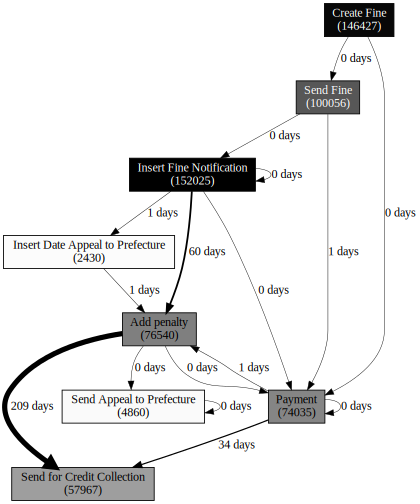

In [240]:
f = draw_process(A,F,D,stats, edge_stats = "time", min_line_thick = 0.5,max_line_thick = 6,plot_size = "7",
                title = "Process Flow (Minimum time in days)")
f

But the story would not be complete if I did not show that the Italian police can also be quite fast in rare cases. Therefore, I also plotted the minimum time for each task in the chart above. Except for 3 process steps, we can see that the Italian police can complete the tasks in less than a day. Hence, it is theoretically possible to have a much more efficient Fine Management Process. 

As a conclusion I leave you with a visualization of all process variants in the Fine Management Process. This reveals the full complexity of the process and should emphasize the importance of a process optimization project.

In [241]:
A,F,D,stats = prepare_process_data(log, variants, time_metric="min",top_variants = "all")

Process Flow (Counts)

Number of process variants:  all
Total number of cases:  150370
%-share of all cases:  100.0 %


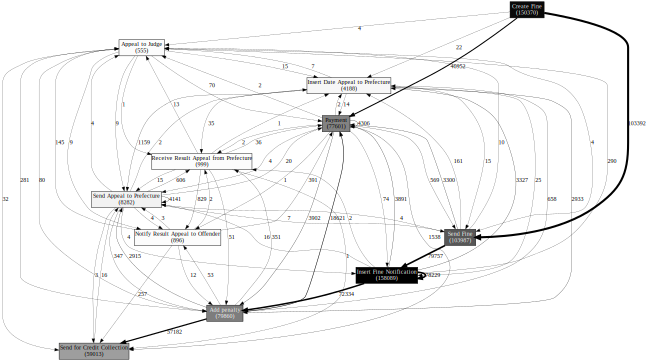

In [246]:
f = draw_process(A,F,D,stats, edge_stats = "count", min_line_thick = 0.7,max_line_thick = 1.3,plot_size = "9",
                title = "Process Flow (Counts)")
f